**Import Section**

Importing relavent packages for the project.

Note: We will ignore warnings for simplicity.

In [60]:
import numpy as py
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

**Creating initial dataframes**]

Following files are available for the project:

1. movie_characters_metadata.tsv
2. movie_conversations.tsv
3. movie_lines.tsv
4. movie_titles_metadata.tsv
5. raw_script_urls


Here are the list of initial dataframes for the respective files:
1. characters_df
2. conversations_df
3. lines_df
4. titles_df
5. rawScript_df


General File Features:
1. Files are tab seperated ('\t').
2. There is no header or footers in any of the files.
3. Few bad rows are present in the files. These rows will be dropped while dataframe creation.


In [61]:
# Creating characters_df dataframe from movie_characters_metadata.tsv

column_names = ['character_id', 'character_name', 'movie_id', 'movie_name', 'character_gender', 'position_credits']
characters_df = pd.read_csv("/content/dataset/movie_characters_metadata.tsv", sep='\t', header=None, names=column_names, on_bad_lines='skip')
print("SUCESS : 'characters_df' dataframe created from 'movie_characters_metadata.tsv'\n")
print('Here is a snapshot of data')
characters_df.head()


SUCESS : 'characters_df' dataframe created from 'movie_characters_metadata.tsv'

Here is a snapshot of data


,character_id,character_name,movie_id,movie_name,character_gender,position_credits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


In [62]:
print("Dimension & metadata of characters_df", characters_df.shape)
print(characters_df.info())

Dimension & metadata of characters_df (9034, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9034 entries, 0 to 9033
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   character_id      9034 non-null   object
 1   character_name    9015 non-null   object
 2   movie_id          9017 non-null   object
 3   movie_name        9017 non-null   object
 4   character_gender  9017 non-null   object
 5   position_credits  9017 non-null   object
dtypes: object(6)
memory usage: 423.6+ KB
None


In [63]:
# Checking on the percentage of NaN for each column in the dataframe

nan_percentage = (characters_df.isna().mean() * 100).round(2)
print("Distribution Of NaN across dataframe")
print(nan_percentage)

Distribution Of NaN across dataframe
character_id        0.00
character_name      0.21
movie_id            0.19
movie_name          0.19
character_gender    0.19
position_credits    0.19
dtype: float64


In [64]:
num_rows_dropped = characters_df.isna().any(axis=1).sum()
print("Number of rows that would be dropped due to NaN:", num_rows_dropped)

Number of rows that would be dropped due to NaN: 19


In [65]:
# Removing rows with NaN values
characters_df = characters_df.dropna()

In [66]:
# Remove duplicate rows
duplicate_counts = characters_df.duplicated().sum()
print("Total duplicate", duplicate_counts)
if duplicate_counts > 0:
  characters_df = characters_df.drop_duplicates()

Total duplicate 0


**Data Cleansing: Removing Ambiguity From The Column Gender**

In this project we are dividing gender to two groups "Male" (M) & "Female" (F).

However during the initial data analysis, it is identified that 5 different types of values are available in the column gender('?', 'm', 'f', 'M', 'F'). On further investigation, it has been confirmed all gender where data is 'm' & 'M' belong to male(M) class and similarly 'f' & 'F' can be grouped as female(F).

The rows with '?' as gender must be dropped as chId is the identifier column for the dataframe and there is no chId with multiple gender so there is no scope for data correction.

In this dataframe 'Male' class will be represented as 'M' & 'Female' class will be represented as 'F'.

In [67]:
##Count of values of each gender type
characters_df.character_gender.value_counts()

?    6006
m    1899
f     921
M     145
F      44
Name: character_gender, dtype: int64

In [68]:
##Data Analysis to check if any chId has multiple gender assigned to it.
##Result: None found
grouped = characters_df.groupby('character_id')['character_gender'].nunique()
ch_id_with_multiple_genders = grouped[grouped > 1].index.tolist()
print("character_ids with more than one gender:", len(ch_id_with_multiple_genders))

character_ids with more than one gender: 0


In [69]:
##Removing data ambiguity from gender
characters_df = characters_df[characters_df.character_gender != '?']
characters_df.character_gender = characters_df.character_gender.apply(lambda g: 'M' if g in ['m', 'M'] else 'F')
print("Data Distribution Per Gender:")
characters_df.character_gender.value_counts()

Data Distribution Per Gender:


M    2044
F     965
Name: character_gender, dtype: int64

**Data Cleansing: Removing non-numeric values from the column posCredits**

As per the column defination, 'posCredits' is  numeric column containing the information of the position where the character features in the credits. Hence this cannot be non-numeric.

Since a significant number of rows (330) contain '?' we will replace it with -1. This would indicate the character didnot appear in the posCredit.


In [70]:
##Find the non-numeric value for posCredits column
non_numeric_posCredits = characters_df.loc[~pd.to_numeric(characters_df['position_credits'], errors='coerce').notna(), 'position_credits'].unique()
print("Non-numeric values in 'posCredits' column:", non_numeric_posCredits)


#Examine the distribution of male & female with this junk data
filtered_df = characters_df[characters_df['position_credits'] == '?']
# Count the number of males and females
male_count = filtered_df[filtered_df['character_gender'] == 'M'].shape[0]
female_count = filtered_df[filtered_df['character_gender'] == 'F'].shape[0]

print("Number of males with posCredits = '?':", male_count)
print("Number of females with posCredits = '?':", female_count)

Non-numeric values in 'posCredits' column: ['?']
Number of males with posCredits = '?': 225
Number of females with posCredits = '?': 105


In [71]:
characters_df['position_credits'] = characters_df['position_credits'].replace('?', -1).astype(int)
characters_df.describe()

,position_credits
count,3009.000000
mean,17.641741
std,111.341380
min,-1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,1000.000000


**Dataframe creation: titles_df**

This dataframe is created from the movie_titles_metadata.tsv file

In [72]:
##Creating the dataframe : titles_df

column_names = ['mId', 'mName', 'mYear', 'mRating', 'mVotes', 'mGenre']
titles_df = pd.read_csv('/content/dataset/movie_titles_metadata.tsv', sep='\t', names=column_names, header=None, on_bad_lines='skip')
print("SUCESS : 'titles_df' dataframe created from 'movie_titles_metadata.tsv'\n")
print('Here is a snapshot of data')
titles_df.head()

SUCESS : 'titles_df' dataframe created from 'movie_titles_metadata.tsv'

Here is a snapshot of data


,mId,mName,mYear,mRating,mVotes,mGenre
0,m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
1,m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
2,m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
3,m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
4,m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


In [73]:
print("Dimension & metadata of the dataframe",titles_df.shape)
print(titles_df.info())

Dimension & metadata of the dataframe (617, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mId      617 non-null    object 
 1   mName    616 non-null    object 
 2   mYear    616 non-null    object 
 3   mRating  616 non-null    float64
 4   mVotes   616 non-null    float64
 5   mGenre   616 non-null    object 
dtypes: float64(2), object(4)
memory usage: 29.0+ KB
None


**Since the number of rows with NAN are very less we will drop rows with NAN**

In [74]:
print("Distribution of NAN across columns in the dataframe")
nan_percentage = (titles_df.isna().mean() * 100).round(2)
print(nan_percentage)

Distribution of NAN across columns in the dataframe
mId        0.00
mName      0.16
mYear      0.16
mRating    0.16
mVotes     0.16
mGenre     0.16
dtype: float64


In [75]:
num_rows_dropped = titles_df.isna().any(axis=1).sum()
print("Number of rows that would be dropped due to NaN:", num_rows_dropped)

Number of rows that would be dropped due to NaN: 1


In [76]:
# Remove rows with NaN values
titles_df = titles_df.dropna()

**No Duplicate to Delete**

In [77]:
# Remove duplicate rows
duplicate_counts = titles_df.duplicated().sum()
print("Total Number of duplicate rows", duplicate_counts)
if duplicate_counts > 0:
  titles_df = titles_df.drop_duplicates()

Total Number of duplicate rows 0


**No data ambiguity in the numeric columns for the dataframe**

In [78]:
titles_df.describe()

,mRating,mVotes
count,616.000000,616.000000
mean,6.865584,49901.698052
std,1.215463,61898.367352
min,2.500000,9.000000
25%,6.200000,9992.500000
50%,7.000000,27121.500000
75%,7.800000,66890.000000
max,9.300000,419312.000000


**Data Cleansing: Removing Data Ambiguity from Year Column**

The column 'mYear' contains information on the year of the movie release. The year information cannot be non-numeric and it has to be in 'YYYY' format.

As shown below, some of the rows contain year appended with a string. As part of preprocessing, the year part is extracted from the string.


In [79]:
column_name = 'mYear'

# Filter non-numeric values in the specified column
non_numeric_values = titles_df.loc[~pd.to_numeric(titles_df[column_name], errors='coerce').notna(), column_name]

# Get unique non-numeric values
unique_non_numeric_values = non_numeric_values.unique()

# Display the unique non-numeric values
print("Unique non-numeric values in column '{}':".format(column_name))
print(unique_non_numeric_values)

Unique non-numeric values in column 'mYear':
['1989/I' '1990/I' '1995/I' '1998/I' '2004/I' '2007/I' '1992/I' '2005/I'
 '2002/I' '1968/I' '1996/I' '2000/I' '2009/I' '2003/I']


In [80]:
column_name = 'mYear'

# Extract numeric portion using regular expression
titles_df[column_name] = titles_df[column_name].str.extract('(\d+)', expand=False)
titles_df[column_name] = titles_df[column_name].astype(int)


**Final Data Snapshot**

In [81]:
titles_df.head()

,mId,mName,mYear,mRating,mVotes,mGenre
0,m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
1,m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
2,m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
3,m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
4,m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


**Dataframe creation: movie_lines**

This dataframe is created from the file: movie_lines.tsv

In [82]:
column_names = ['lId', 'chId', 'mId', 'chName', 'chLine']
lines_df = pd.read_csv('/content/dataset/movie_lines.tsv', sep='\t', header=None,names=column_names, on_bad_lines='skip')
print("SUCESS : 'lines_df' dataframe created from 'movie_lines.tsv'\n")
print('Here is a snapshot of data')
lines_df.head()


SUCESS : 'lines_df' dataframe created from 'movie_lines.tsv'

Here is a snapshot of data


,lId,chId,mId,chName,chLine
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [83]:
print("Dimension & metadata of lines_df", lines_df.shape)
print(lines_df.info())

Dimension & metadata of lines_df (293202, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293202 entries, 0 to 293201
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   lId     293202 non-null  object
 1   chId    288917 non-null  object
 2   mId     288917 non-null  object
 3   chName  288874 non-null  object
 4   chLine  288663 non-null  object
dtypes: object(5)
memory usage: 11.2+ MB
None


**Analysing the NAN in the dataframe**

The number of rows with NAN is quite significant. However if we see the distribution of NAN across columns we see it is quite uniform.

On further data analysis it has been proved that we must drop the rows with NAN as no significant infomation is conveyed.

In [84]:
##Checking on the percentage of NaN for each column in the dataframe

print("Distribution Of NaN across dataframe")
nan_percentage = (lines_df.isna().mean() * 100).round(2)
print(nan_percentage)

Distribution Of NaN across dataframe
lId       0.00
chId      1.46
mId       1.46
chName    1.48
chLine    1.55
dtype: float64


In [85]:
#Number of rows with all column as NAN except lId (lId is the primary analysis)
num_rows_all_null = lines_df.drop('lId', axis=1).isna().all(axis=1).sum()
print("Number of rows with all columns (except 'lId') as null:", num_rows_all_null)

print("Dropping these rows")
lines_df = lines_df[~lines_df.drop('lId', axis=1).isna().all(axis=1)]

Number of rows with all columns (except 'lId') as null: 4285
Dropping these rows


In [86]:
##Number of row where any column is NAN
num_rows_dropped = lines_df.isna().any(axis=1).sum()
print("Additional rows with NaN:", num_rows_dropped)

Additional rows with NaN: 297


In [87]:
rows_with_nan = lines_df[lines_df.isna().any(axis=1)]
rows_with_nan.head()

,lId,chId,mId,chName,chLine
538,L474,u5,m0,KAT,NaN
5468,L24609,u224,m14,SYKES,NaN
35993,L239088,u1125,m74,JANOSZ,NaN
44272,L283548,u1356,m90,BRUCE,NaN
48729,L303243,u1475,m100,JOE,NaN


**For the sake of simplicity we will drop the rows with NaN**

In [88]:
lines_df = lines_df.dropna()

In [89]:
# Remove duplicate rows
duplicate_counts = lines_df.duplicated().sum()
print("Total duplicates: ",duplicate_counts)
if duplicate_counts > 0:
  lines_df = lines_df.drop_duplicates()

Total duplicates:  0


**Size Of The Data After Dropping NAN**

In [90]:
print("Size of data post-processing",lines_df.shape)

Size of data post-processing (288620, 5)


**Dataframe Creation: conversations_df**

This dataframe is created using the file movie_conversations.tsv

In [91]:
column_names = ['chId1', 'chId2','mId', 'lineList']
conversations_df = pd.read_csv('/content/dataset/movie_conversations.tsv', sep='\t',names=column_names, header=None, on_bad_lines='skip')
print("SUCESS : 'conversations_df' dataframe created from 'movie_conversations.tsv'\n")
print('Here is a snapshot of data')

conversations_df.head()

SUCESS : 'conversations_df' dataframe created from 'movie_conversations.tsv'

Here is a snapshot of data


,chId1,chId2,mId,lineList
0,u0,u2,m0,['L194' 'L195' 'L196' 'L197']
1,u0,u2,m0,['L198' 'L199']
2,u0,u2,m0,['L200' 'L201' 'L202' 'L203']
3,u0,u2,m0,['L204' 'L205' 'L206']
4,u0,u2,m0,['L207' 'L208']


**Analysis Of NAN values**

In [92]:
print("Distribution of NAN across all column of dataframe")
nan_percentage = (conversations_df.isna().mean() * 100).round(2)
print(nan_percentage)

Distribution of NAN across all column of dataframe
chId1       0.0
chId2       0.0
mId         0.0
lineList    0.0
dtype: float64


**Duplicate Row Analysis**

In [93]:
# Remove duplicate rows
duplicate_counts = lines_df.duplicated().sum()
print("Total Number Of Duplicates: ", duplicate_counts)
if duplicate_counts > 0:
  lines_df = lines_df.drop_duplicates()

Total Number Of Duplicates:  0


In [94]:
print("Size And Metadata for the dataframe", conversations_df.shape)
print(conversations_df.info())

Size And Metadata for the dataframe (83097, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83097 entries, 0 to 83096
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   chId1     83097 non-null  object
 1   chId2     83097 non-null  object
 2   mId       83097 non-null  object
 3   lineList  83097 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB
None


**Dataframe Creation: rawScript_df**

Here we create dataframe using the file raw_script_urls.tsv

In [95]:
column_names = ['mId','mName','url']
rawScript_df = pd.read_csv('/content/dataset/raw_script_urls.tsv', sep='\t', names=column_names, header=None,on_bad_lines='skip')
rawScript_df.head()

,mId,mName,url
0,m0,10 things i hate about you,http://www.dailyscript.com/scripts/10Things.html
1,m1,1492: conquest of paradise,http://www.hundland.org/scripts/1492-ConquestO...
2,m2,15 minutes,http://www.dailyscript.com/scripts/15minutes.html
3,m3,2001: a space odyssey,http://www.scifiscripts.com/scripts/2001.txt
4,m4,48 hrs.,http://www.awesomefilm.com/script/48hours.txt


In [96]:
print("Size And Metadata for the dataframe", rawScript_df.shape)
print(rawScript_df.info())

Size And Metadata for the dataframe (617, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mId     617 non-null    object
 1   mName   616 non-null    object
 2   url     616 non-null    object
dtypes: object(3)
memory usage: 14.6+ KB
None


**Analysis of Nan values**

After detailed analysis, we have decided to drop the single row with Nan as it will have minimal impact on the model.

In [97]:
nan_percentage = (rawScript_df.isna().mean() * 100).round(2)
print(nan_percentage)

mId      0.00
mName    0.16
url      0.16
dtype: float64


In [98]:
num_rows_dropped = rawScript_df.isna().any(axis=1).sum()
print("Number of rows that would be dropped due to NaN:", num_rows_dropped)

Number of rows that would be dropped due to NaN: 1


In [99]:
# Remove rows with NaN values
rawScript_df = rawScript_df.dropna()

**Duplicate Analysis**

In [100]:
# Remove duplicate rows
duplicate_counts = rawScript_df.duplicated().sum()
print("Total Number Of Duplicates: ", duplicate_counts)
if duplicate_counts > 0:
  rawScript_df = rawScript_df.drop_duplicates()

Total Number Of Duplicates:  0


Here are the list of initial dataframes:
1. characters_df
2. titles_df
3. conversations_df
4. rawScript_df
5. lines_df

**Creating the final dataframe**

First we analyse the impact of data merging of different dataframe. The dataframe that we will merge : characters_df, titles_df, lines_df

**Merging  characters_df & titles_df**

As show below, number of unique movies in the characters_df is 599.

We need to do left/inner join between characters_df & titles_df as number of unique movies is lower in characters_df and our majority information on each character is available in characters_df. We will join on the 'mId' columns.

In [101]:
unique_movies_count = characters_df['movie_id'].nunique()
print("Number of unique movies:", unique_movies_count)

Number of unique movies: 599


In [102]:
titles_df

,mId,mName,mYear,mRating,mVotes,mGenre
0,m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
1,m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
2,m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
3,m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
4,m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']
...,...,...,...,...,...,...
612,m612,watchmen,2009,7.8,135229.0,['action' 'crime' 'fantasy' 'mystery' 'sci-fi'...
613,m613,xxx,2002,5.6,53505.0,['action' 'adventure' 'crime']
614,m614,x-men,2000,7.4,122149.0,['action' 'sci-fi']
615,m615,young frankenstein,1974,8.0,57618.0,['comedy' 'sci-fi']


In [103]:
# Movies in titles_df but not in characters_df
movies_in_titles_not_in_characters = set(titles_df['mId']) - set(characters_df['movie_id'])

# Movies in characters_df but not in titles_df
movies_in_characters_not_in_titles = set(characters_df['movie_id']) - set(titles_df['mId'])

# Convert the sets to lists for easier handling or further analysis
movies_in_titles_not_in_characters_list = list(movies_in_titles_not_in_characters)
movies_in_characters_not_in_titles_list = list(movies_in_characters_not_in_titles)

print("Movies in titles_df but not in characters_df:", movies_in_titles_not_in_characters_list)
print("Movies in characters_df but not in titles_df:", movies_in_characters_not_in_titles_list)


Movies in titles_df but not in characters_df: ['m600', 'm135', 'm321', 'm412', 'm338', 'm521', 'm406', 'm237', 'm616', 'm602', 'm535', 'm614', 'm484', 'm270', 'm456', 'm483', 'm364']
Movies in characters_df but not in titles_df: []


In [104]:
titles_df = titles_df.rename(columns={"mId": "movie_id"})

In [105]:
titles_df

,movie_id,mName,mYear,mRating,mVotes,mGenre
0,m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
1,m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
2,m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
3,m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
4,m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']
...,...,...,...,...,...,...
612,m612,watchmen,2009,7.8,135229.0,['action' 'crime' 'fantasy' 'mystery' 'sci-fi'...
613,m613,xxx,2002,5.6,53505.0,['action' 'adventure' 'crime']
614,m614,x-men,2000,7.4,122149.0,['action' 'sci-fi']
615,m615,young frankenstein,1974,8.0,57618.0,['comedy' 'sci-fi']


In [106]:
detailed_characters_df = characters_df.merge(titles_df[['movie_id', 'mYear', 'mRating', 'mVotes', 'mGenre']], on='movie_id', how='left')
print("Dimension Of Charaters Dataframe",characters_df.shape)
print("Dimension Of Merged Character Dataframe",detailed_characters_df.shape)
detailed_characters_df.head()

Dimension Of Charaters Dataframe (3009, 6)
Dimension Of Merged Character Dataframe (3009, 10)


,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance']
1,u2,CAMERON,m0,10 things i hate about you,M,3,1999,6.9,62847.0,['comedy' 'romance']
2,u4,JOEY,m0,10 things i hate about you,M,6,1999,6.9,62847.0,['comedy' 'romance']
3,u5,KAT,m0,10 things i hate about you,F,2,1999,6.9,62847.0,['comedy' 'romance']
4,u6,MANDELLA,m0,10 things i hate about you,F,7,1999,6.9,62847.0,['comedy' 'romance']


**Duplicate And NAN Analysis Of Merged Dataframe**

As expected no duplicates or NAN found in the merged data

In [107]:
duplicate_counts = detailed_characters_df.duplicated().sum()
print("Total Number Of Duplicates: ", duplicate_counts)

Total Number Of Duplicates:  0


In [108]:
nan_percentage = (detailed_characters_df.isna().mean() * 100).round(2)
print(nan_percentage)

character_id        0.0
character_name      0.0
movie_id            0.0
movie_name          0.0
character_gender    0.0
position_credits    0.0
mYear               0.0
mRating             0.0
mVotes              0.0
mGenre              0.0
dtype: float64


**Final Dataframe Creation**

Understanding the distribution of data lines_df & detailed_characters_df based on chId


In [109]:
detailed_characters_df

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance']
1,u2,CAMERON,m0,10 things i hate about you,M,3,1999,6.9,62847.0,['comedy' 'romance']
2,u4,JOEY,m0,10 things i hate about you,M,6,1999,6.9,62847.0,['comedy' 'romance']
3,u5,KAT,m0,10 things i hate about you,F,2,1999,6.9,62847.0,['comedy' 'romance']
4,u6,MANDELLA,m0,10 things i hate about you,F,7,1999,6.9,62847.0,['comedy' 'romance']
...,...,...,...,...,...,...,...,...,...,...
3004,u9015,ELIZABETH,m615,young frankenstein,F,25,1974,8.0,57618.0,['comedy' 'sci-fi']
3005,u9017,FREDDY,m615,young frankenstein,M,-1,1974,8.0,57618.0,['comedy' 'sci-fi']
3006,u9019,IGOR,m615,young frankenstein,M,3,1974,8.0,57618.0,['comedy' 'sci-fi']
3007,u9020,INGA,m615,young frankenstein,F,5,1974,8.0,57618.0,['comedy' 'sci-fi']


In [110]:
# Characters in lines_df but not in detailed_characters_df
characters_in_lines_not_in_merged = set(lines_df['chId']) - set(detailed_characters_df['character_id'])

# Characters in merged_df but not in lines_df
characters_in_merged_not_in_lines = set(detailed_characters_df['character_id']) - set(lines_df['chId'])

# Convert the sets to lists for easier handling or further analysis
characters_in_lines_not_in_merged_list = list(characters_in_lines_not_in_merged)
characters_in_merged_not_in_lines_list = list(characters_in_merged_not_in_lines)

print("Characters in lines_df but not in detailed_characters_df:", characters_in_lines_not_in_merged_list)
print("Characters in detailed_characters_df but not in lines_df:", characters_in_merged_not_in_lines_list)


Characters in lines_df but not in detailed_characters_df: ['u2409', 'u4334', 'u6910', 'u1131', 'u8477', 'u1723', 'u3959', 'u654', 'u7248', 'u2477', 'u7396', 'u4053', 'u6176', 'u4796', 'u5842', 'u5502', 'u6663', 'u6693', 'u94', 'u3236', 'u7731', 'u3726', 'u8793', 'u2110', 'u8857', 'u5707', 'u7402', 'u2818', 'u2078', 'u1256', 'u3173', 'u3066', 'u2168', 'u197', 'u5571', 'u8967', 'u573', 'u5023', 'u4045', 'u5401', 'u3268', 'u6403', 'u2038', 'u522', 'u6521', 'u7708', 'u6300', 'u3853', 'u8884', 'u3643', 'u1165', 'u3539', 'u1607', 'u1254', 'u9028', 'u6550', 'u1665', 'u8238', 'u8454', 'u6122', 'u2186', 'u6042', 'u3634', 'u3229', 'u1932', 'u3995', 'u6057', 'u8432', 'u23', 'u6669', 'u8635', 'u3441', 'u24', 'u4529', 'u7393', 'u2057', 'u8551', 'u5490', 'u631', 'u376', 'u8161', 'u2565', 'u4230', 'u6960', 'u305', 'u1027', 'u6724', 'u5472', 'u1298', 'u2020', 'u2905', 'u6825', 'u8603', 'u2307', 'u2577', 'u3021', 'u3811', 'u4861', 'u829', 'u3650', 'u1014', 'u4236', 'u2430', 'u5458', 'u8320', 'u559', 'u

When the primary key column of lines_df is removed we are expected to have duplicate row as there can be reapeated dialogue by same charater. This can be filtered out as they would not impact the learning of our model.

Now the final dataframe df should be created by merging lines_df_mod & detailed_characters_df by inner join. As expected no duplicates or NAN after merging

In [111]:
##When we remove the lId we may see charaters repeating dialogues
lines_df_mod = lines_df[['chId', 'mId', 'chName', 'chLine']]

# Remove duplicate rows
duplicate_counts = lines_df_mod.duplicated().sum()
print("Total Number Of Duplicates: ", duplicate_counts)
if duplicate_counts > 0:
   lines_df_mod = lines_df_mod.drop_duplicates()

lines_df_mod.shape

Total Number Of Duplicates:  5438


(283182, 4)

In [112]:
lines_df_mod
lines_df_mod = lines_df_mod.rename(columns={"chId": "character_id", "mId": "movie_id"})

In [113]:
detailed_characters_df

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance']
1,u2,CAMERON,m0,10 things i hate about you,M,3,1999,6.9,62847.0,['comedy' 'romance']
2,u4,JOEY,m0,10 things i hate about you,M,6,1999,6.9,62847.0,['comedy' 'romance']
3,u5,KAT,m0,10 things i hate about you,F,2,1999,6.9,62847.0,['comedy' 'romance']
4,u6,MANDELLA,m0,10 things i hate about you,F,7,1999,6.9,62847.0,['comedy' 'romance']
...,...,...,...,...,...,...,...,...,...,...
3004,u9015,ELIZABETH,m615,young frankenstein,F,25,1974,8.0,57618.0,['comedy' 'sci-fi']
3005,u9017,FREDDY,m615,young frankenstein,M,-1,1974,8.0,57618.0,['comedy' 'sci-fi']
3006,u9019,IGOR,m615,young frankenstein,M,3,1974,8.0,57618.0,['comedy' 'sci-fi']
3007,u9020,INGA,m615,young frankenstein,F,5,1974,8.0,57618.0,['comedy' 'sci-fi']


In [114]:
detailed_characters_df

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance']
1,u2,CAMERON,m0,10 things i hate about you,M,3,1999,6.9,62847.0,['comedy' 'romance']
2,u4,JOEY,m0,10 things i hate about you,M,6,1999,6.9,62847.0,['comedy' 'romance']
3,u5,KAT,m0,10 things i hate about you,F,2,1999,6.9,62847.0,['comedy' 'romance']
4,u6,MANDELLA,m0,10 things i hate about you,F,7,1999,6.9,62847.0,['comedy' 'romance']
...,...,...,...,...,...,...,...,...,...,...
3004,u9015,ELIZABETH,m615,young frankenstein,F,25,1974,8.0,57618.0,['comedy' 'sci-fi']
3005,u9017,FREDDY,m615,young frankenstein,M,-1,1974,8.0,57618.0,['comedy' 'sci-fi']
3006,u9019,IGOR,m615,young frankenstein,M,3,1974,8.0,57618.0,['comedy' 'sci-fi']
3007,u9020,INGA,m615,young frankenstein,F,5,1974,8.0,57618.0,['comedy' 'sci-fi']


In [115]:
lines_df_mod

,character_id,movie_id,chName,chLine
0,u0,m0,BIANCA,They do not!
1,u2,m0,CAMERON,They do to!
2,u0,m0,BIANCA,I hope so.
3,u2,m0,CAMERON,She okay?
4,u0,m0,BIANCA,Let's go.
...,...,...,...,...
293197,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...
293198,u9034,m616,VEREKER,I'm to take the Sikali with the main column to...
293199,u9030,m616,DURNFORD,Your orders Mr Vereker?
293200,u9030,m616,DURNFORD,Good ones yes Mr Vereker. Gentlemen who can ri...


In [116]:
df = detailed_characters_df.merge(lines_df_mod, on=['character_id', 'movie_id'], how='inner')
df.head()

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre,chName,chLine
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,They do not!
1,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,I hope so.
2,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Let's go.
3,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Okay -- you're gonna need to learn how to lie.
4,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Like my fear of wearing pastels?


In [117]:
df

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre,chName,chLine
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,They do not!
1,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,I hope so.
2,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Let's go.
3,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Okay -- you're gonna need to learn how to lie.
4,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Like my fear of wearing pastels?
...,...,...,...,...,...,...,...,...,...,...,...,...
224198,u9022,MEDICAL STUDENT,m615,young frankenstein,M,9,1974,8.0,57618.0,['comedy' 'sci-fi'],MEDICAL STUDENT,Dr. Fronkonsteen!
224199,u9022,MEDICAL STUDENT,m615,young frankenstein,M,9,1974,8.0,57618.0,['comedy' 'sci-fi'],MEDICAL STUDENT,Well sir... I'm not sure I understand the dist...
224200,u9022,MEDICAL STUDENT,m615,young frankenstein,M,9,1974,8.0,57618.0,['comedy' 'sci-fi'],MEDICAL STUDENT,But aren't you the grandson of the famous Dr. ...
224201,u9022,MEDICAL STUDENT,m615,young frankenstein,M,9,1974,8.0,57618.0,['comedy' 'sci-fi'],MEDICAL STUDENT,Oh! I thought it was Dr. Frankenstein.


**Additional check to ensure data merging has not added redundant data**

In [118]:
# # Filter rows where chName_x does not match chName_y
# mismatched_names_df = df[df['chName_x'] != df['chName_y']]

# # Display the rows with mismatched names
# print("Rows with mismatched chName_x and chName_y:")
# print(mismatched_names_df)

In [119]:
# df['chName'] = df['chName_x']
# df = df.drop(['chName_y','chName_x'], axis=1)
# df.head()

**Analysis Of NAN & Duplicates**

In [120]:
nan_percentage = (df.isna().mean() * 100).round(2)
print(nan_percentage)

character_id        0.0
character_name      0.0
movie_id            0.0
movie_name          0.0
character_gender    0.0
position_credits    0.0
mYear               0.0
mRating             0.0
mVotes              0.0
mGenre              0.0
chName              0.0
chLine              0.0
dtype: float64


In [121]:
# Remove duplicate rows
duplicate_counts = df.duplicated().sum()
print("Total Number Of Duplicates: ", duplicate_counts)
if duplicate_counts > 0:
   df = df.drop_duplicates()
df.shape

Total Number Of Duplicates:  0


(224203, 12)

**Adding Additional  Columns**

**dialoguesCount** : Number of unique dialogues per character

**charCountPerDialogue** : Number of character per dialogue

**wordCountPerDialogue** : Length of the dialogue.


In [122]:
df

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre,chName,chLine
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,They do not!
1,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,I hope so.
2,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Let's go.
3,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Okay -- you're gonna need to learn how to lie.
4,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Like my fear of wearing pastels?
...,...,...,...,...,...,...,...,...,...,...,...,...
224198,u9022,MEDICAL STUDENT,m615,young frankenstein,M,9,1974,8.0,57618.0,['comedy' 'sci-fi'],MEDICAL STUDENT,Dr. Fronkonsteen!
224199,u9022,MEDICAL STUDENT,m615,young frankenstein,M,9,1974,8.0,57618.0,['comedy' 'sci-fi'],MEDICAL STUDENT,Well sir... I'm not sure I understand the dist...
224200,u9022,MEDICAL STUDENT,m615,young frankenstein,M,9,1974,8.0,57618.0,['comedy' 'sci-fi'],MEDICAL STUDENT,But aren't you the grandson of the famous Dr. ...
224201,u9022,MEDICAL STUDENT,m615,young frankenstein,M,9,1974,8.0,57618.0,['comedy' 'sci-fi'],MEDICAL STUDENT,Oh! I thought it was Dr. Frankenstein.


In [123]:
##Get the number of unique dialogues spoken by each characters.
df['dialoguesCount'] = df.groupby(['character_id', 'movie_id'])['chLine'].transform('count')

##Get the number of characters per dialogue
df['charCountPerDialogue'] = df.chLine.str.len()

##Get the number of words per dialogue
df['wordCountPerDialogue'] = df.chLine.str.count(' ') + 1

**Final Data Snapshot**

In [124]:
df.head()

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre,chName,chLine,dialoguesCount,charCountPerDialogue,wordCountPerDialogue
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,They do not!,92,12,3
1,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,I hope so.,92,10,3
2,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Let's go.,92,9,2
3,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Okay -- you're gonna need to learn how to lie.,92,46,10
4,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,Like my fear of wearing pastels?,92,32,6


## Exploratory Data Analysis

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224203 entries, 0 to 224202
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   character_id          224203 non-null  object 
 1   character_name        224203 non-null  object 
 2   movie_id              224203 non-null  object 
 3   movie_name            224203 non-null  object 
 4   character_gender      224203 non-null  object 
 5   position_credits      224203 non-null  int64  
 6   mYear                 224203 non-null  int64  
 7   mRating               224203 non-null  float64
 8   mVotes                224203 non-null  float64
 9   mGenre                224203 non-null  object 
 10  chName                224203 non-null  object 
 11  chLine                224203 non-null  object 
 12  dialoguesCount        224203 non-null  int64  
 13  charCountPerDialogue  224203 non-null  int64  
 14  wordCountPerDialogue  224203 non-null  int64  
dtype

Our Dataframe has 14 different columns with over 224000 rows of data

In [126]:
print(df.character_id.unique())
len(df.character_id.unique())

['u0' 'u2' 'u4' ... 'u9019' 'u9020' 'u9022']


2951

In [127]:
print(df.movie_id.unique())
len(df.movie_id.unique())

['m0' 'm1' 'm2' 'm3' 'm4' 'm5' 'm6' 'm7' 'm8' 'm9' 'm10' 'm11' 'm12' 'm13'
 'm14' 'm15' 'm16' 'm17' 'm18' 'm19' 'm20' 'm21' 'm22' 'm23' 'm24' 'm25'
 'm26' 'm27' 'm28' 'm29' 'm30' 'm31' 'm32' 'm33' 'm34' 'm35' 'm36' 'm37'
 'm38' 'm39' 'm40' 'm41' 'm42' 'm43' 'm44' 'm45' 'm46' 'm47' 'm48' 'm49'
 'm50' 'm51' 'm52' 'm53' 'm54' 'm55' 'm56' 'm57' 'm58' 'm59' 'm60' 'm61'
 'm62' 'm63' 'm64' 'm65' 'm66' 'm67' 'm68' 'm69' 'm70' 'm71' 'm72' 'm73'
 'm74' 'm75' 'm76' 'm77' 'm78' 'm79' 'm80' 'm82' 'm83' 'm84' 'm86' 'm87'
 'm88' 'm89' 'm90' 'm91' 'm92' 'm93' 'm94' 'm95' 'm96' 'm97' 'm98' 'm99'
 'm100' 'm101' 'm102' 'm103' 'm104' 'm105' 'm106' 'm109' 'm110' 'm111'
 'm112' 'm113' 'm114' 'm115' 'm117' 'm118' 'm119' 'm120' 'm121' 'm122'
 'm123' 'm124' 'm125' 'm126' 'm127' 'm128' 'm129' 'm130' 'm131' 'm132'
 'm133' 'm134' 'm136' 'm137' 'm138' 'm139' 'm140' 'm141' 'm142' 'm143'
 'm144' 'm145' 'm146' 'm147' 'm148' 'm149' 'm150' 'm151' 'm152' 'm153'
 'm154' 'm155' 'm156' 'm157' 'm158' 'm159' 'm160' 'm161' 'm

588

***The cleaned dataframe contains data for over 2951 Unique characters from 588 different movies across a variety of genres like Comedy, Drama, Sci-fi, Horror, etc***

### Creating Wordcloud out of Movie Names

In [128]:
movie_names_df = df.drop_duplicates(subset = "movie_id")
movie_names_df.movie_name

0         10 things i hate about you
616       1492: conquest of paradise
758                       15 minutes
1272           2001: a space odyssey
1413                         48 hrs.
                     ...            
222349              the wizard of oz
222814       the world is not enough
223093                      watchmen
223397                           xxx
223732            young frankenstein
Name: movie_name, Length: 588, dtype: object

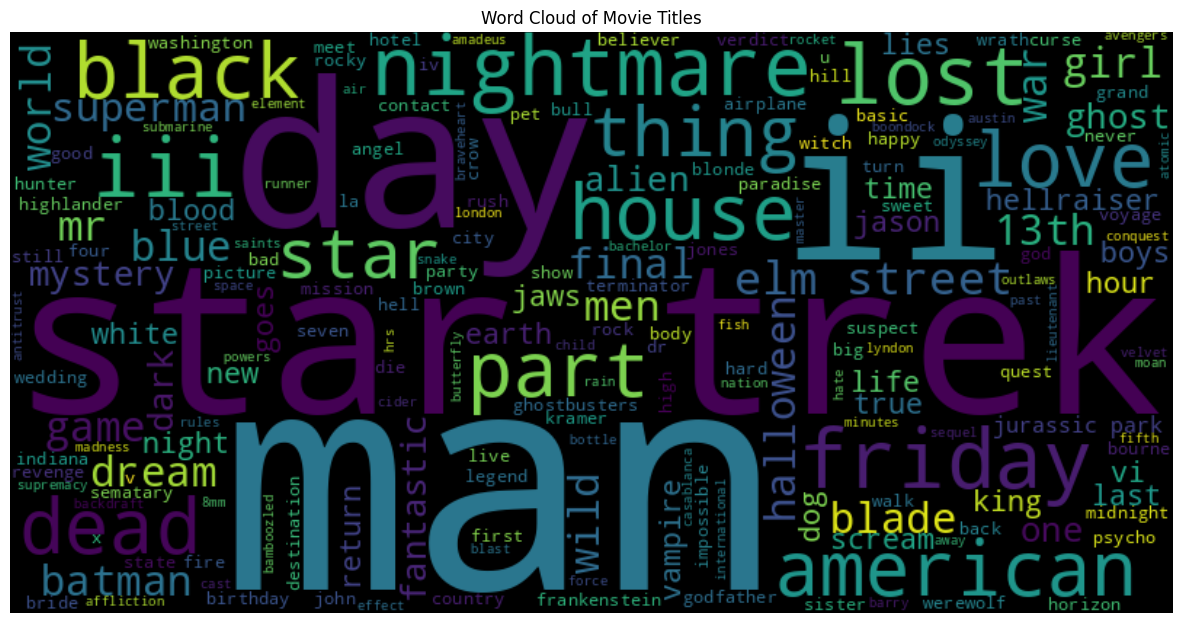

In [130]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#Concatenate all dialogue lines
all_lines = ' '.join(movie_names_df['movie_name'])

#Create a word cloud with larger figure size
plt.figure(figsize=(15, 10))
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_lines)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Titles')
plt.show()

The most frequent words in the movie titles are **“star”, “trek”, “black”, “men”, “day”, “night”, “american”, “dead”, “thing”, “house”, “nightmare”, “elm”, “street”, “batman”, “jurassic”, “park”, “wild”, “lost”, “world”, “brown”, “jaws”, “mission”, “impossible”, “voyage”, “earth”, “game”, “happy”, “hotel”, “meet”, “hard”, “scream”, “basic”, “rush”, “13th”, “part”, “final”, “blue”, “hellraiser”, “dark”, “friday”, “thing”, “scream” **.

<br>



Based on this word cloud, we can conclude that the most common themes in the movie titles are related to **science fiction, horror, action, and adventure genres**. The words “star”, “trek”, “black”, “men”, “day”, “night”, “american”, “dead”, “thing”, “house”, “nightmare”, “elm”, “street”, “batman”, “jurassic”, “park”, “wild”, “lost”, “world”, “brown”, “jaws”, “mission”, “impossible”, “voyage”, “earth”, “game”, “happy”, “hotel”, “meet”, “hard”, “scream”, “basic”, “rush”, “13th”, “part”, “final”, “blue”, “hellraiser”, “dark”, “friday”, “thing”, and “scream” are indicative of the most popular movie franchises and titles in these genres.

### Creating Wordcloud out of Character Names

In [131]:
character_names_df = df.drop_duplicates(subset = "character_id")
character_names_df.character_name

0                  BIANCA
92                CAMERON
167                  JOEY
203                   KAT
350              MANDELLA
               ...       
223732          ELIZABETH
223775             FREDDY
224020               IGOR
224118               INGA
224189    MEDICAL STUDENT
Name: character_name, Length: 2951, dtype: object

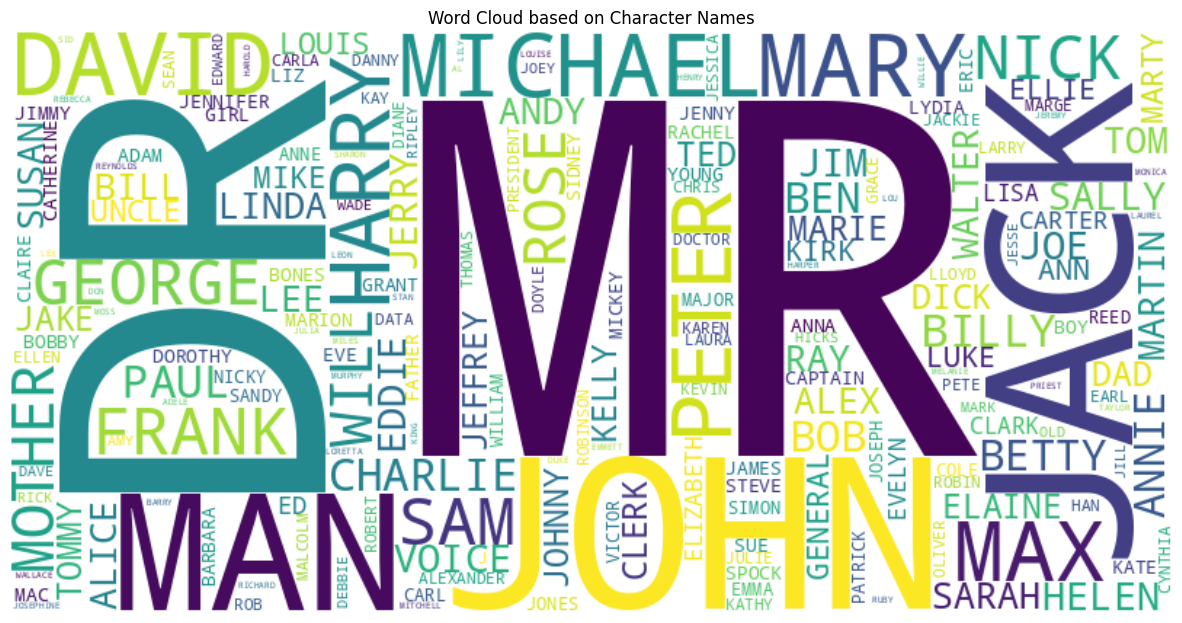

In [132]:
from wordcloud import WordCloud

#Concatenate all dialogue lines
all_lines = ' '.join(character_names_df['character_name'])

#Create a word cloud with larger figure size
plt.figure(figsize=(15, 10))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lines)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud based on Character Names')
plt.show()

Based on the word cloud, we can conclude that the most common character names in the 588 movies are ***Jack, John, Michael, George, and Nick***. We can also see that there are other names that are less common, but still appear in the word cloud such as ***Paul, Sam, Betty, Kirk, and Tom***.

### Gender Distribution of movie Characters across movies in given data

In [133]:
Gender_distribution = df.drop_duplicates(subset = "character_id")
Gender_distribution

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre,chName,chLine,dialoguesCount,charCountPerDialogue,wordCountPerDialogue
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,They do not!,92,12,3
92,u2,CAMERON,m0,10 things i hate about you,M,3,1999,6.9,62847.0,['comedy' 'romance'],CAMERON,They do to!,75,11,3
167,u4,JOEY,m0,10 things i hate about you,M,6,1999,6.9,62847.0,['comedy' 'romance'],JOEY,Listen I want to talk to you about the prom.,36,44,10
203,u5,KAT,m0,10 things i hate about you,F,2,1999,6.9,62847.0,['comedy' 'romance'],KAT,Perm?,147,5,1
350,u6,MANDELLA,m0,10 things i hate about you,F,7,1999,6.9,62847.0,['comedy' 'romance'],MANDELLA,William - he asked me to meet him here.,25,39,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223732,u9015,ELIZABETH,m615,young frankenstein,F,25,1974,8.0,57618.0,['comedy' 'sci-fi'],ELIZABETH,So this is what it's like to be completely happy!,43,49,10
223775,u9017,FREDDY,m615,young frankenstein,M,-1,1974,8.0,57618.0,['comedy' 'sci-fi'],FREDDY,I think we all need a good night's sleep. Why...,245,97,21
224020,u9019,IGOR,m615,young frankenstein,M,3,1974,8.0,57618.0,['comedy' 'sci-fi'],IGOR,Miss me?,98,8,2
224118,u9020,INGA,m615,young frankenstein,F,5,1974,8.0,57618.0,['comedy' 'sci-fi'],INGA,Sweetheart.....Is this really you???,71,36,4


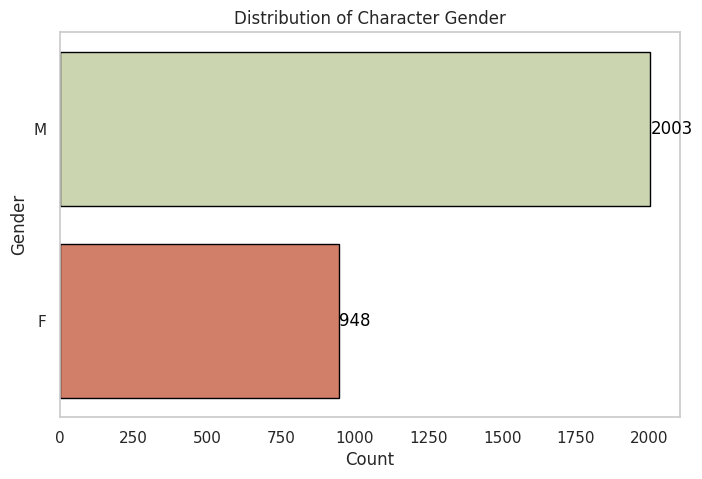

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in 'character_gender'
gender_counts = Gender_distribution['character_gender'].value_counts()

# Create a horizontal bar plot using seaborn with custom colors
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
ax = sns.barplot(x=gender_counts.values, y=gender_counts.index, palette=['#cedcab', '#e27557'], edgecolor='black')

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Gender')
plt.title('Distribution of Character Gender')

# Remove grid lines
ax.grid(False)

# Add count labels on the bars
for i, v in enumerate(gender_counts.values):
    ax.text(v + 0.1, i, str(v), color='black', ha='left', va='center')

# Show the plot
plt.show()

We have total of **2951 Characters** across 588 Movies.

Out of these ***2003 Characters are of Male Gender and 948 Female***

### Now, Let's see how the data for movies is distributed over the years italicized text

In [135]:
movie_year_df = df.drop_duplicates(subset = "movie_id")
movie_year_df

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre,chName,chLine,dialoguesCount,charCountPerDialogue,wordCountPerDialogue
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,They do not!,92,12,3
616,u16,COLUMBUS,m1,1492: conquest of paradise,M,1,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history'],COLUMBUS,Asia can be found to the west -- and I will pr...,117,53,13
758,u26,CUTLER,m2,15 minutes,M,-1,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller'],CUTLER,Officers there's your killer do your duty arre...,24,53,9
1272,u50,BOWMAN,m3,2001: a space odyssey,M,1,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi'],BOWMAN,Roger.,57,6,1
1413,u67,CATES,m4,48 hrs.,M,1,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller'],CATES,Where's ganz?,220,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222349,u8950,DOROTHY,m610,the wizard of oz,F,1,1939,8.3,104873.0,['adventure' 'family' 'fantasy' 'musical'],DOROTHY,No Aunt Em -- this was a real truly live place...,170,100,22
222814,u8965,BOND,m611,the world is not enough,M,1,1999,6.3,60047.0,['action' 'adventure' 'thriller'],BOND,I love Christmas in Turkey.,130,27,5
223093,u8979,DR. MANHATTAN,m612,watchmen,M,2,2009,7.8,135229.0,['action' 'crime' 'fantasy' 'mystery' 'sci-fi'...,DR. MANHATTAN,WHAT ARE YOU DOING VEIDT?,35,25,5
223397,u8991,GIBBONS,m613,xxx,M,4,2002,5.6,53505.0,['action' 'adventure' 'crime'],GIBBONS,All for show. Just a psychological mind game t...,51,78,16


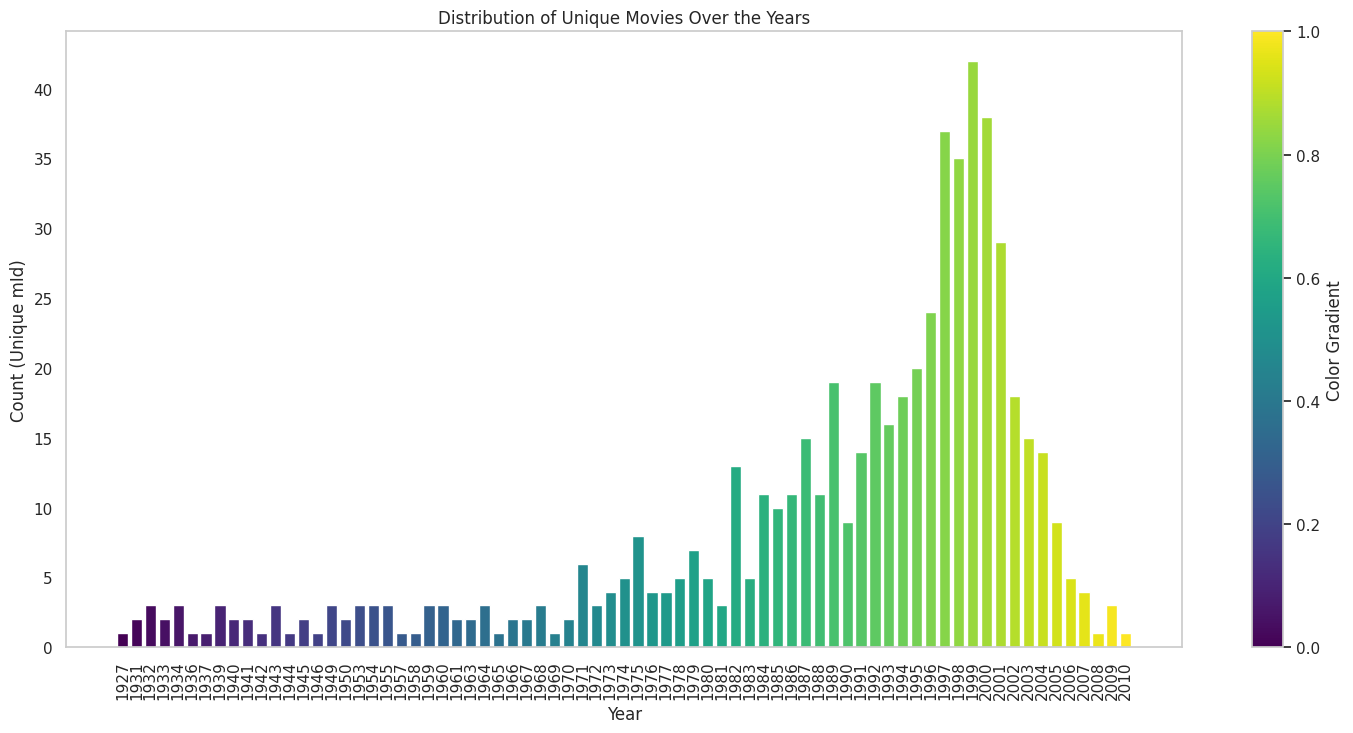

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable

# Count the occurrences of each year based on unique mId values
year_counts_unique = movie_year_df.groupby('mYear')['movie_id'].nunique()

# Create a color gradient
colors = plt.cm.viridis(np.linspace(0, 1, len(year_counts_unique)))

# Create a bar plot for year distribution based on unique mId
plt.figure(figsize=(18, 8))  # Adjust the figure size as needed
bars = plt.bar(year_counts_unique.index.astype(str), year_counts_unique, color=colors)
plt.xlabel('Year')
plt.ylabel('Count (Unique mId)')
plt.title('Distribution of Unique Movies Over the Years')

# Remove grids
plt.grid(False)

# Create a ScalarMappable to create a colorbar
sm = ScalarMappable(cmap=plt.cm.viridis)
sm.set_array([])  # An array must be set, but it can be empty

# Add a color bar for the gradient
color_bar = plt.colorbar(sm, orientation='vertical', pad=0.05)
color_bar.set_label('Color Gradient')

# Adjust x-axis limits for a little space on both sides
plt.margins(x=0.05)

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

The data ranges from the year 1926 all the way upto 2010. While we have wide-ranging data, the majority of it lies in the 3 decades of the 1980s, 1990s and 2000s, with 490 of the 617 i.e., ∼79% of the movies in that period. This sample space has enough of a time-spread for us to analyze how representation of women and the general attitude towards them in movies has changed over time.

### Analysing Movies for Ratings Received

In [137]:
movie_rating_df = df.drop_duplicates(subset = "movie_id")
movie_rating_df

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre,chName,chLine,dialoguesCount,charCountPerDialogue,wordCountPerDialogue
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,They do not!,92,12,3
616,u16,COLUMBUS,m1,1492: conquest of paradise,M,1,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history'],COLUMBUS,Asia can be found to the west -- and I will pr...,117,53,13
758,u26,CUTLER,m2,15 minutes,M,-1,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller'],CUTLER,Officers there's your killer do your duty arre...,24,53,9
1272,u50,BOWMAN,m3,2001: a space odyssey,M,1,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi'],BOWMAN,Roger.,57,6,1
1413,u67,CATES,m4,48 hrs.,M,1,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller'],CATES,Where's ganz?,220,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222349,u8950,DOROTHY,m610,the wizard of oz,F,1,1939,8.3,104873.0,['adventure' 'family' 'fantasy' 'musical'],DOROTHY,No Aunt Em -- this was a real truly live place...,170,100,22
222814,u8965,BOND,m611,the world is not enough,M,1,1999,6.3,60047.0,['action' 'adventure' 'thriller'],BOND,I love Christmas in Turkey.,130,27,5
223093,u8979,DR. MANHATTAN,m612,watchmen,M,2,2009,7.8,135229.0,['action' 'crime' 'fantasy' 'mystery' 'sci-fi'...,DR. MANHATTAN,WHAT ARE YOU DOING VEIDT?,35,25,5
223397,u8991,GIBBONS,m613,xxx,M,4,2002,5.6,53505.0,['action' 'adventure' 'crime'],GIBBONS,All for show. Just a psychological mind game t...,51,78,16


In [138]:
movie_rating_df.mRating.describe()

count    588.000000
mean       6.867347
std        1.216800
min        2.500000
25%        6.200000
50%        7.100000
75%        7.800000
max        9.300000
Name: mRating, dtype: float64

We observe that the highest Rated movie had 9.3 Rating

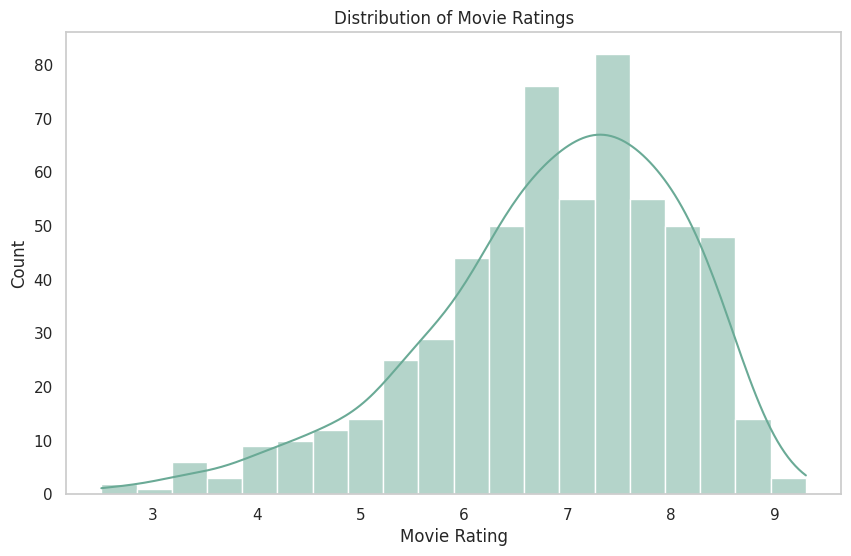

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

#Assuming your analysis DataFrame is named analysis_df
#Extract the 'mRating' column for plotting
movie_ratings = movie_rating_df['mRating']

#Create a histogram for movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings, bins=20, kde=True, color='#6aaa96')
plt.xlabel('Movie Rating')
plt.ylabel('Count')
plt.title('Distribution of Movie Ratings')

# Remove grids
plt.grid(False)

#Show the plot
plt.show()

Based on the graph, we can conclude that the majority of the movies have a rating between 6 and 8. The highest number of ratings is around 7.5. This suggests that most movies are rated between 6 and 8, with a few outliers on either end.

**9.5 is the highest rating received by any movie in our current dataset.**

### Let's Explore dialogue count per Gender

In [140]:
gender_dialogue_df = df.drop_duplicates(subset = "character_id")
gender_dialogue_df

,character_id,character_name,movie_id,movie_name,character_gender,position_credits,mYear,mRating,mVotes,mGenre,chName,chLine,dialoguesCount,charCountPerDialogue,wordCountPerDialogue
0,u0,BIANCA,m0,10 things i hate about you,F,4,1999,6.9,62847.0,['comedy' 'romance'],BIANCA,They do not!,92,12,3
92,u2,CAMERON,m0,10 things i hate about you,M,3,1999,6.9,62847.0,['comedy' 'romance'],CAMERON,They do to!,75,11,3
167,u4,JOEY,m0,10 things i hate about you,M,6,1999,6.9,62847.0,['comedy' 'romance'],JOEY,Listen I want to talk to you about the prom.,36,44,10
203,u5,KAT,m0,10 things i hate about you,F,2,1999,6.9,62847.0,['comedy' 'romance'],KAT,Perm?,147,5,1
350,u6,MANDELLA,m0,10 things i hate about you,F,7,1999,6.9,62847.0,['comedy' 'romance'],MANDELLA,William - he asked me to meet him here.,25,39,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223732,u9015,ELIZABETH,m615,young frankenstein,F,25,1974,8.0,57618.0,['comedy' 'sci-fi'],ELIZABETH,So this is what it's like to be completely happy!,43,49,10
223775,u9017,FREDDY,m615,young frankenstein,M,-1,1974,8.0,57618.0,['comedy' 'sci-fi'],FREDDY,I think we all need a good night's sleep. Why...,245,97,21
224020,u9019,IGOR,m615,young frankenstein,M,3,1974,8.0,57618.0,['comedy' 'sci-fi'],IGOR,Miss me?,98,8,2
224118,u9020,INGA,m615,young frankenstein,F,5,1974,8.0,57618.0,['comedy' 'sci-fi'],INGA,Sweetheart.....Is this really you???,71,36,4


In [141]:
dialogue_per_gender = gender_dialogue_df.groupby('character_gender')['dialoguesCount'].sum()

In [142]:
dialogue_per_gender

character_gender
F     66353
M    157850
Name: dialoguesCount, dtype: int64

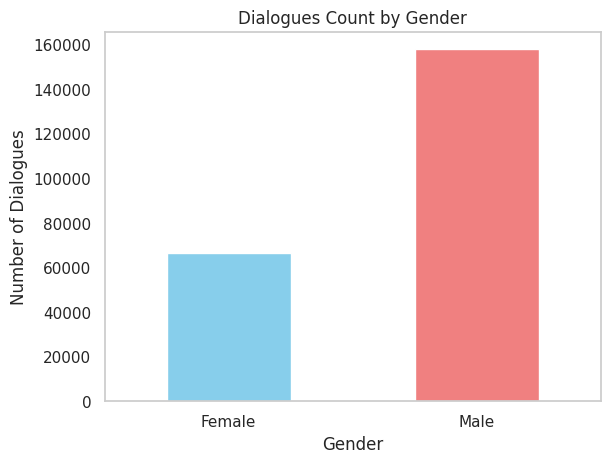

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
dialogue_df = pd.DataFrame({'Gender':['Female', 'Male'], 'dialogue_per_gender':[dialogue_per_gender[0], dialogue_per_gender[1]]})

# Create a bar plot
ax = dialogue_df.plot.bar(x='Gender', y='dialogue_per_gender', rot=0, color=['skyblue', 'lightcoral'])
ax.get_legend().remove()
# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Number of Dialogues')
plt.title('Dialogues Count by Gender')
plt.grid(False)
# Show the plot
plt.show()

The bar graph illustrates the distribution of dialogues between female and male characters.The data indicates that male characters have significantly more dialogues **(157,850)** compared to female characters **(66,353)**. This suggests a potential gender imbalance in the dataset or narrative focus.

The substantial difference in dialogue counts raises questions about the representation of female characters in the context of the dataset. The analysis may prompt further investigation into the storyline, genre, or specific characters contributing to these numbers.